In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle

# Aggregate and extract all variables (takes time and memory)

We are not considering the aggregation if there is nan at any time step (that aggregation is replaced by zero to make sure that it should not come in the list of top 10 events)

In [2]:
# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"

file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# Define aggregation intervals (assuming 5‑min time steps)
intervals = {'10min': 2, '1h': 12}
interval_order = ['10min', '1h']

# Initialize dictionaries
event_windows_noNAN_all_stations = {}
file_station_mapping = {}
station_name_count = {}

for file_name in file_list:
    file_path = os.path.join(directory_path, file_name)
    
    with xr.open_dataset(file_path) as data:
        # Extract station name and clean it
        station_name = data.attrs.get('Station_name', 'Unknown Station').strip()
        
        # Clean station names by removing/standardizing unwanted terms
        station_name_clean = station_name.replace("AWS", "").strip()

        # Store file-station mapping
        file_station_mapping[file_name] = station_name_clean

        # Required variables
        required_vars = ['Precipitation', 'Precipitation Quality', 
                         'Temperature', 'Temperature Quality',
                         'Dew Point Temperature', 'Dew Point Temperature Quality', 
                         'Average Wind Speed', 'Average Wind Speed Quality']
        
        # Check for missing variables
        available_vars = list(data.variables)
        missing_vars = [var for var in required_vars if var not in available_vars]
        if missing_vars:
            print(f"Skipping {station_name_clean}: Missing variables {missing_vars}")
            continue  # Skip this station if required variables are missing
        
        # Extract data
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']
        temp = data['Temperature']
        temp_q = data['Temperature Quality']
        dew_point_temp = data['Dew Point Temperature']
        dew_point_temp_q = data['Dew Point Temperature Quality']
        wind_speed = data['Average Wind Speed']
        wind_speed_q = data['Average Wind Speed Quality']
        
        # Apply quality filters
        ppt = ppt.where(ppt_q.astype(str) == 'Y')
        ppt = ppt.where(ppt <= 50)
        temp = temp.where(temp_q == 'Y')
        dew_point_temp = dew_point_temp.where(dew_point_temp_q == 'Y')
        wind_speed = wind_speed.where(wind_speed_q == 'Y')
        
        # Calculate Relative Humidity
        rh = 100 * (np.exp((17.27 * dew_point_temp) / (dew_point_temp + 237.3)) /
                    np.exp((17.27 * temp) / (temp + 237.3)))
        rh = np.round(rh, 2)
        rh.name = 'Relative Humidity'
        
        # Convert each variable to DataFrame and set Time as the index
        def to_dataframe(var, var_name):
            df = var.to_dataframe().reset_index()
            df['Time'] = pd.to_datetime(df['Time'])
            df = df.set_index('Time')
            df = df.rename(columns={df.columns[-1]: var_name})
            return df
        
        ppt_df = to_dataframe(ppt, 'Precipitation')
        temp_df = to_dataframe(temp, 'Temperature')
        rh_df = to_dataframe(rh, 'Relative Humidity')
        wind_speed_df = to_dataframe(wind_speed, 'Wind Speed')

        # Aggregate data
        all_vars_aggregated_data = {}
        for interval, window in intervals.items():
            df = pd.DataFrame(index=ppt_df.index)
            df['Precipitation'] = ppt_df['Precipitation'].rolling(window=window, min_periods=1).apply(lambda x: 0 if np.isnan(x).any() else x.sum(), raw=True)
            df['Temperature'] = temp_df['Temperature'].rolling(window=window, min_periods=1).mean()
            df['Relative Humidity'] = rh_df['Relative Humidity'].rolling(window=window, min_periods=1).mean()
            df['Wind Speed'] = wind_speed_df['Wind Speed'].rolling(window=window, min_periods=1).mean()
            
            # Store aggregated data
            all_vars_aggregated_data[interval] = df.reset_index()

        # Save the extracted event windows
        event_windows_noNAN_all_stations[station_name_clean] = all_vars_aggregated_data

In [3]:
# save
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations.pkl', 'wb') as f:
    pickle.dump(event_windows_noNAN_all_stations, f)

In [ ]:
%%time

# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# Define aggregation intervals (assuming 5-min time steps)
# For example, for 10min: window=2 (2 * 5min), for 1h: window=12 (12 * 5min)
intervals = {'10min': 2, '1h': 12}
interval_order = ['10min', '1h']

# Initialize dictionaries
event_windows_noNAN_all_stations_revised = {}
file_station_mapping = {}
station_name_count = {}

def custom_rolling_sum(s, window):
    """Vectorized rolling sum that returns 0 if the window has any NaN, else returns the sum."""
    rsum = s.rolling(window=window, min_periods=window).sum()
    rcount = s.rolling(window=window, min_periods=window).count()
    # For complete window, count equals window; otherwise, set to 0
    return rsum.where(rcount == window, 0)

# Process each file (each station)
for file_name in file_list:
    file_path = os.path.join(directory_path, file_name)
    
    with xr.open_dataset(file_path) as data:
        # Extract and clean station name from attributes
        station_name = data.attrs.get('Station_name', 'Unknown Station').strip()
        station_name_clean = station_name.replace("AWS", "").strip()
        file_station_mapping[file_name] = station_name_clean

        # Check for required variables
        required_vars = ['Precipitation', 'Precipitation Quality', 
                         'Temperature', 'Temperature Quality',
                         'Dew Point Temperature', 'Dew Point Temperature Quality', 
                         'Average Wind Speed', 'Average Wind Speed Quality']
        missing_vars = [var for var in required_vars if var not in data.variables]
        if missing_vars:
            print(f"Skipping {station_name_clean}: Missing {missing_vars}")
            continue

        # Extract data variables
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']
        temp = data['Temperature']
        temp_q = data['Temperature Quality']
        dew_point_temp = data['Dew Point Temperature']
        dew_point_temp_q = data['Dew Point Temperature Quality']
        wind_speed = data['Average Wind Speed']
        wind_speed_q = data['Average Wind Speed Quality']

        # Apply quality filters
        ppt = ppt.where(ppt_q.astype(str) == 'Y').where(ppt <= 50)
        temp = temp.where(temp_q == 'Y')
        dew_point_temp = dew_point_temp.where(dew_point_temp_q == 'Y')
        wind_speed = wind_speed.where(wind_speed_q == 'Y')

        # Calculate Relative Humidity
        rh = 100 * (np.exp((17.27 * dew_point_temp) / (dew_point_temp + 237.3)) /
                    np.exp((17.27 * temp) / (temp + 237.3)))
        rh = np.round(rh, 2)
        rh.name = 'Relative Humidity'

        # Function to convert variable to DataFrame (only once per variable)
        def to_df(var, var_name):
            df = var.to_dataframe().reset_index()
            df['Time'] = pd.to_datetime(df['Time'])
            df = df.set_index('Time')
            df = df.rename(columns={df.columns[-1]: var_name})
            return df

        ppt_df = to_df(ppt, 'Precipitation')
        temp_df = to_df(temp, 'Temperature')
        rh_df = to_df(rh, 'Relative Humidity')
        wind_speed_df = to_df(wind_speed, 'Wind Speed')

        # Initialize dictionary to store aggregated data
        ppt_aggregated = {}
        for interval, window in intervals.items():
            # For precipitation: use custom rolling sum to ensure full data; for others, standard rolling mean.
            agg_df = pd.DataFrame(index=ppt_df.index)
            agg_df['Precipitation'] = custom_rolling_sum(ppt_df['Precipitation'], window)
            agg_df['Temperature'] = temp_df['Temperature'].rolling(window=window, min_periods=window).mean()
            agg_df['Relative Humidity'] = rh_df['Relative Humidity'].rolling(window=window, min_periods=window).mean()
            agg_df['Wind Speed'] = wind_speed_df['Wind Speed'].rolling(window=window, min_periods=window).mean()
            ppt_aggregated[interval] = agg_df.reset_index()

        # Store aggregated data for the station
        event_windows_noNAN_all_stations_revised[station_name_clean] = ppt_aggregated

In [ ]:
# save
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations_revised.pkl', 'wb') as f:
    pickle.dump(event_windows_noNAN_all_stations_revised, f)

CPU times: user 2min 59s, sys: 17.7 s, total: 3min 17s
Wall time: 7min 48s


# Selecting top 10 events (takes time and memory)

In [5]:
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations.pkl', 'rb') as f:
    event_windows_all_stations = pickle.load(f)

interval_order = ['10min', '1h']

In [14]:
# Initialize a dictionary to store top events for each station
top_10_events_all_stations = {}

for station_name, all_vars_aggregated_data in event_windows_all_stations.items():
    top_10_events = {}
    
    for interval in interval_order:
        if interval in all_vars_aggregated_data:
            # Extract the precipitation data and copy it
            df = all_vars_aggregated_data[interval][['Time', 'Precipitation']].copy()
            # Set the 'Time' column as the index for proper time-based operations
            df.set_index('Time', inplace=True)
            
            # Calculate the 90th percentile for the 'Precipitation' column
            percentiles = df['Precipitation'].quantile(0.90)
            
            # Filter rows where precipitation exceeds the 90th percentile and is greater than 0.2 mm
            filtered_df = df[(df['Precipitation'] >= percentiles) & (df['Precipitation'] > 0.2)]
            
            # Identify pseudo-independent events (local maxima)
            maxima_df = filtered_df[
                (filtered_df.shift(-1).fillna(-1) <= filtered_df) & 
                (filtered_df.shift(1).fillna(-1) <= filtered_df)
            ]
            
            # Identify the highest precipitation per day for each column
            daily_max = maxima_df.groupby(maxima_df.index.date)['Precipitation'].max()
            
            # Identify the exact timestamp of these daily maxima
            daily_max_times = maxima_df.groupby(maxima_df.index.date)['Precipitation'].idxmax()
            
            # Initialize a list to store valid daily maximum events
            max_events_per_day_list = []
            
            # Collect valid daily maximum events
            valid_times = daily_max_times.dropna()
            if not valid_times.empty:
                values = maxima_df['Precipitation'].loc[valid_times].dropna()
                df_col = pd.DataFrame({'Precipitation': values}, index=valid_times)
                max_events_per_day_list.append(df_col)
            
            # Only attempt concatenation if the list is non-empty
            if max_events_per_day_list:
                max_events_per_day = pd.concat(max_events_per_day_list, axis=1)
                
                # Convert index to datetime and sort
                max_events_per_day.index = pd.to_datetime(max_events_per_day.index)
                max_events_per_day.sort_index(inplace=True)
                
                # Handle consecutive high-rainfall days:
                max_events_per_day['Date'] = max_events_per_day.index.date  # Extract date
                max_events_per_day['Group'] = (pd.to_datetime(max_events_per_day.index).diff() > pd.Timedelta(days=1)).cumsum()
                
                # Select the highest value from each consecutive period (group)
                selected_events = max_events_per_day.groupby('Group')['Precipitation'].idxmax()
                
                # Extract the top 10 events from these selected days
                top_10_events[interval] = max_events_per_day.loc[selected_events].nlargest(10, 'Precipitation')
            else:
                print(f"No valid extreme events for station {station_name} at interval {interval}")
    
    # Store results only if there are events for the station
    if top_10_events:
        top_10_events_all_stations[station_name] = top_10_events

# (Optional) To view the output for a station:
for station, events in top_10_events_all_stations.items():
    print(f"Station: {station}")
    for interval, df in events.items():
        print(f"  Interval: {interval}")
        print(df)

No valid extreme events for station FRANKSTON BEACH at interval 10min
No valid extreme events for station FRANKSTON BEACH at interval 1h
Station: FERNY CREEK (DUNNS HILL)
  Interval: 10min
                     Precipitation        Date  Group
Precipitation                                        
2010-09-22 17:15:00           20.0  2010-09-22    782
2011-02-04 19:00:00           19.0  2011-02-04    816
2004-01-29 14:55:00           15.2  2004-01-29    262
2007-12-03 11:50:00           12.8  2007-12-03    566
2010-12-01 15:10:00           11.6  2010-12-01    801
2006-11-02 14:45:00           11.2  2006-11-02    481
2010-09-07 18:10:00           10.4  2010-09-07    777
2003-12-02 18:40:00            9.4  2003-12-02    255
2009-10-30 23:25:00            9.4  2009-10-30    700
2004-12-09 14:20:00            9.2  2004-12-09    346
  Interval: 1h
                     Precipitation        Date  Group
Precipitation                                        
2011-02-04 19:50:00           49.4  2011

In [15]:
# save
with open(f'{directory_path}/p2_top_10_events_all_stations.pkl', 'wb') as f:
    pickle.dump(top_10_events_all_stations, f)

# Heatmap of top 10 events

In [2]:
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
with open(f'{directory_path}/p2_top_10_events_all_stations.pkl', 'rb') as f:
    top_10_events_all_stations = pickle.load(f)

interval_order = ['10min', '1h']


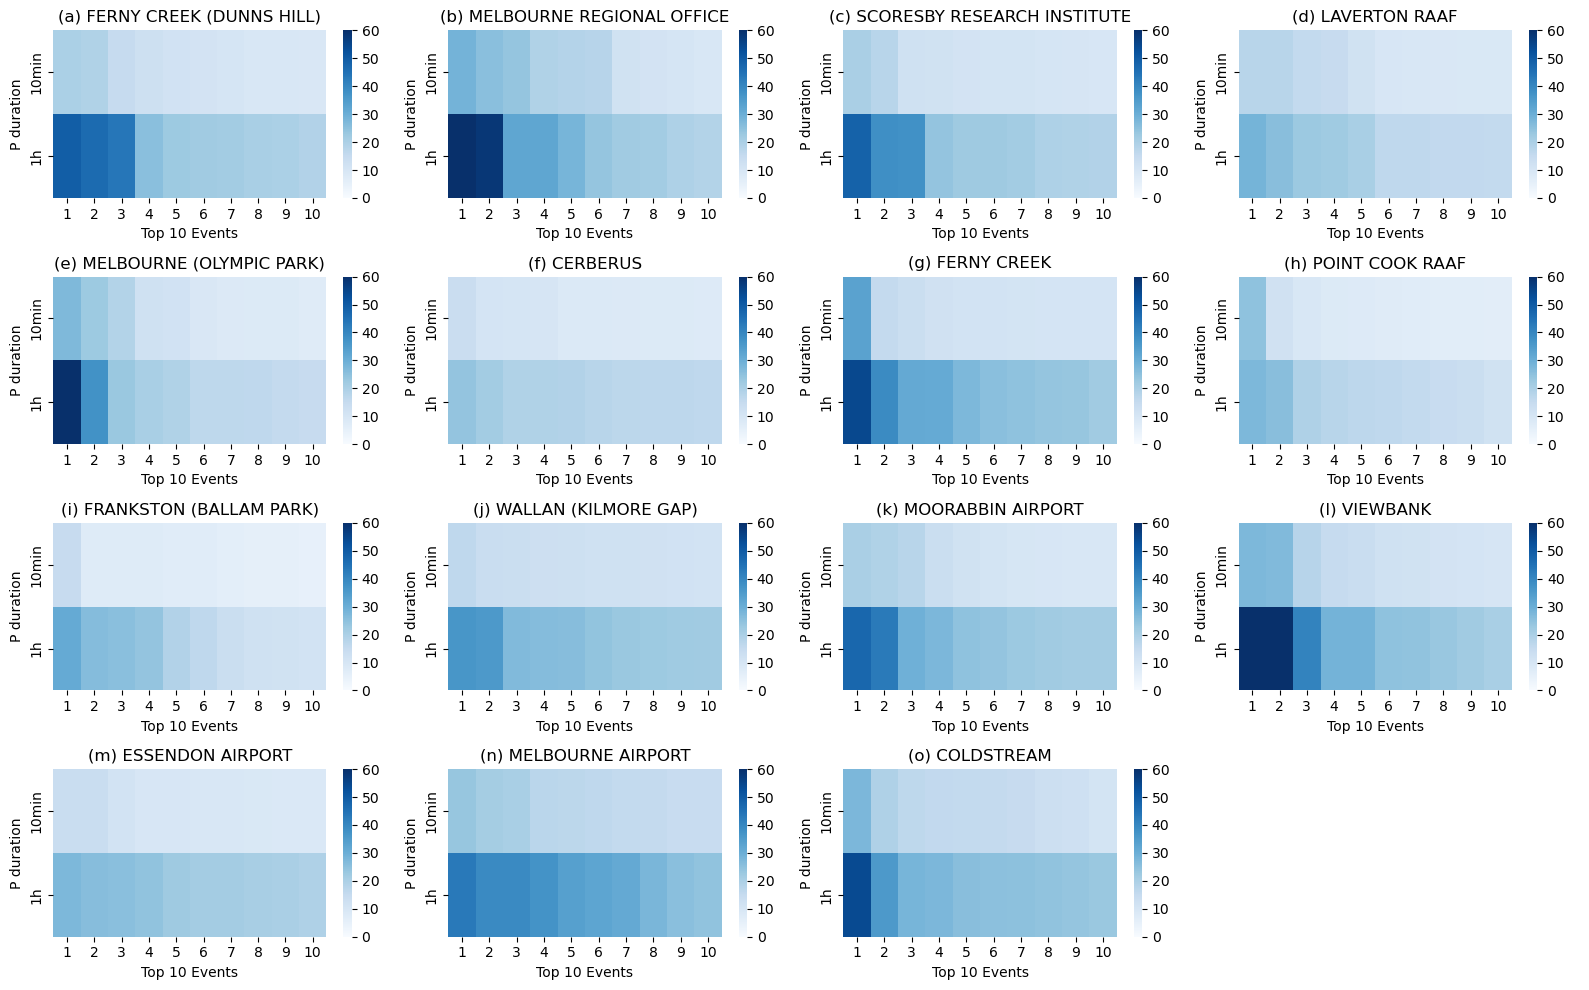

In [18]:
shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'

def plot_heatmap_per_station():
    num_stations = len(top_10_events_all_stations)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, (station, events) in enumerate(top_10_events_all_stations.items()):
        if idx >= 24:  # Ensure we don't exceed the subplot grid
            break
        
        event_data = []
        for interval in interval_order:
            if interval in events and not events[interval].empty:  # Ensure valid data
                df = events[interval][['Precipitation']].copy()
                for rank, value in enumerate(df['Precipitation'].values, 1):
                    event_data.append([interval, rank, value])
        
        if event_data:
            # Create DataFrame
            event_df = pd.DataFrame(event_data, columns=['Interval', 'Rank', 'Precipitation'])
            event_df['Interval'] = pd.Categorical(event_df['Interval'], categories=interval_order, ordered=True)
            event_df_pivot = event_df.pivot(index='Interval', columns='Rank', values='Precipitation')

            # Create heatmap
            sns.heatmap(event_df_pivot, cmap='Blues', annot=False, fmt='.1f', ax=axes[idx], vmin=0, vmax=60)

            # Subplot label
            subplot_label = string.ascii_lowercase[idx]  # Labels: (a), (b), (c), etc.
            axes[idx].set_title(f"({subplot_label}) {station}")
            axes[idx].set_xlabel('Top 10 Events')
            axes[idx].set_ylabel('P duration')

    # Hide unused subplots
    for i in range(num_stations, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # plt.savefig('/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p2_heatmap_top10.png', format='png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{shape_path}/figure/top_10_heatmap_{target_region}_all_stations.jpg', format='jpg', dpi=300, bbox_inches='tight')

    plt.show()

# Call the function to plot all stations
plot_heatmap_per_station()

# Filtering common events across all frequenices

In [3]:
# Define the interval order
# interval_order = ['5min', '10min', '20min', '30min', '1h']

# Create a new dictionary to hold the filtered events
filtered_top_10_events_all_stations = {}

for station, events in top_10_events_all_stations.items():
    common_dates = None  # Holds the intersection of dates across all available intervals

    # Identify common dates across available intervals
    for interval in interval_order:
        if interval in events and not events[interval].empty:
            dates = set(events[interval]['Date'].unique())
            common_dates = dates if common_dates is None else common_dates.intersection(dates)

    # If common dates exist, filter each DataFrame accordingly
    if common_dates:
        filtered_events = {
            interval: events[interval][events[interval]['Date'].isin(common_dates)]
            for interval in interval_order if interval in events and not events[interval].empty
        }
        if filtered_events:  # Only store if there are matching events
            filtered_top_10_events_all_stations[station] = filtered_events

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")


Filtering complete. 15 stations have common events.


# Heatmap of common events

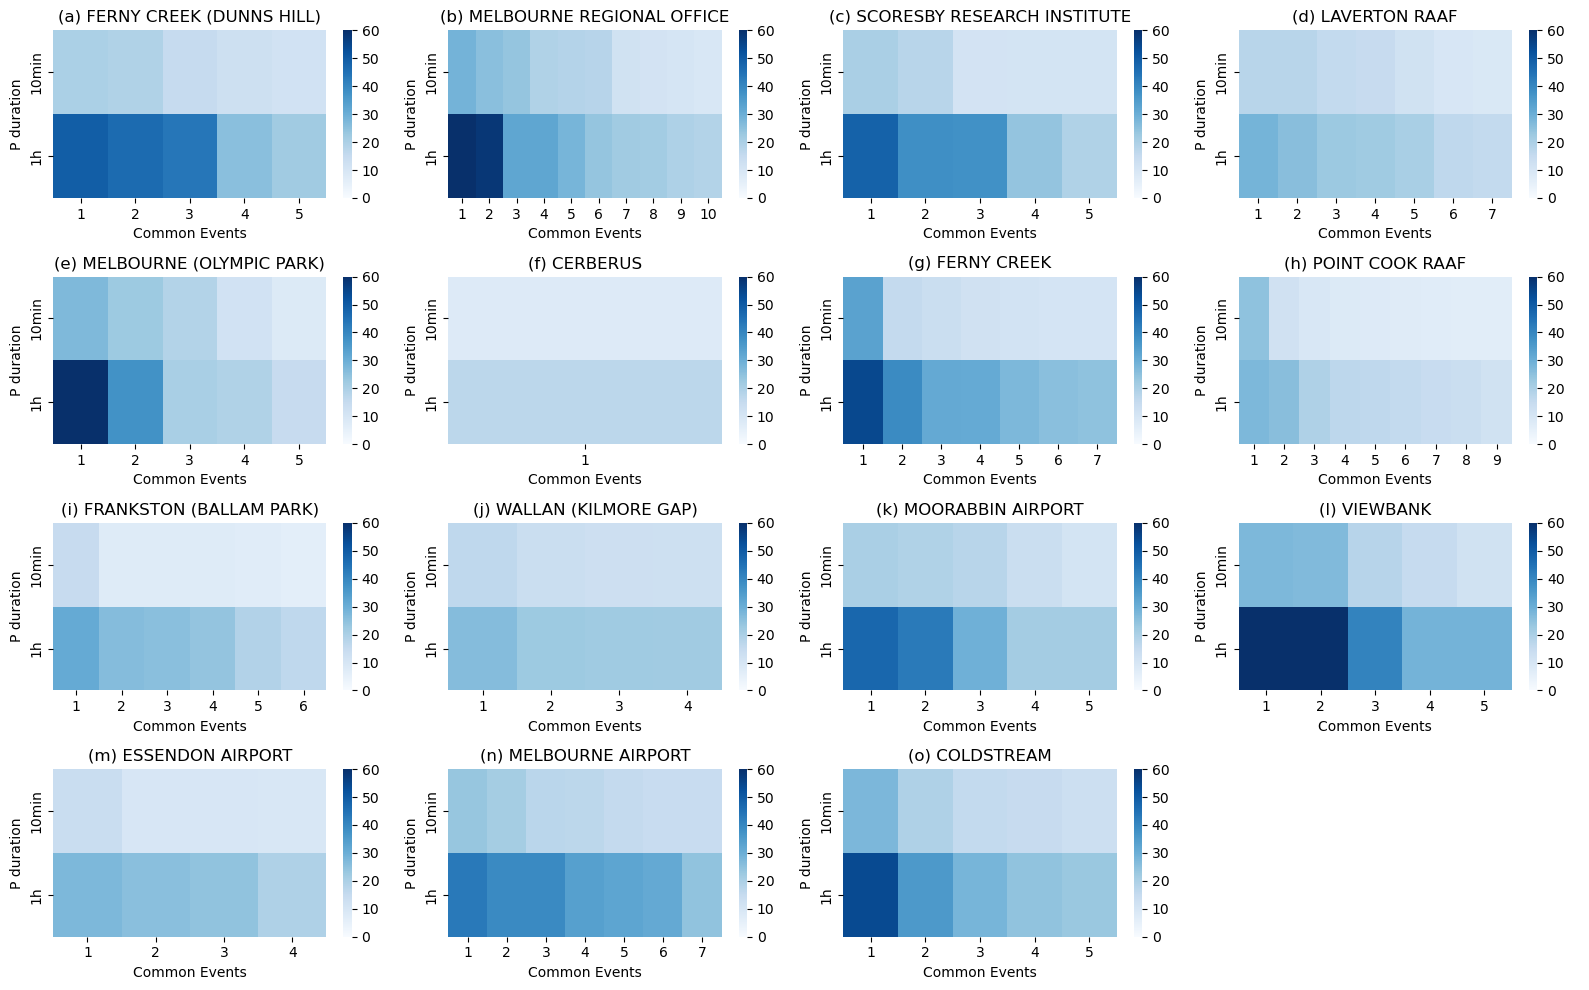

In [20]:
# Function to plot heatmaps for filtered events
def plot_filtered_heatmap_per_station():
    num_stations = len(filtered_top_10_events_all_stations)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10))  # Adjust grid size for your data
    axes = axes.flatten()

    for idx, (station, events) in enumerate(filtered_top_10_events_all_stations.items()):
        if idx >= 24:  # Ensure we don't exceed the subplot grid
            break

        event_data = []
        for interval in interval_order:
            if interval in events:
                df = events[interval][['Date', 'Precipitation']].copy()
                for rank, value in enumerate(df['Precipitation'].values, 1):
                    event_data.append([interval, rank, value])

        if event_data:
            # Create DataFrame from the event data
            event_df = pd.DataFrame(event_data, columns=['Interval', 'Rank', 'Precipitation'])
            event_df['Interval'] = pd.Categorical(event_df['Interval'], categories=interval_order, ordered=True)
            event_df_pivot = event_df.pivot(index='Interval', columns='Rank', values='Precipitation')

            # Plot heatmap
            sns.heatmap(event_df_pivot, cmap='Blues', annot=False, fmt='.1f', ax=axes[idx], vmin=0, vmax=60)

            # Subplot label
            subplot_label = string.ascii_lowercase[idx]  # Labels: (a), (b), (c), etc.
            axes[idx].set_title(f"({subplot_label}) {station}")
            axes[idx].set_xlabel('Common Events')
            axes[idx].set_ylabel('P duration')

    # Hide any unused subplots
    for i in range(num_stations, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    
    plt.savefig(f'{shape_path}/figure/top_10_heatmap_{target_region}_all_stations_common.jpg', format='jpg', dpi=300, bbox_inches='tight')

    plt.show()

# Call the function to plot all stations
plot_filtered_heatmap_per_station()


Filtering complete. 15 stations have common events.


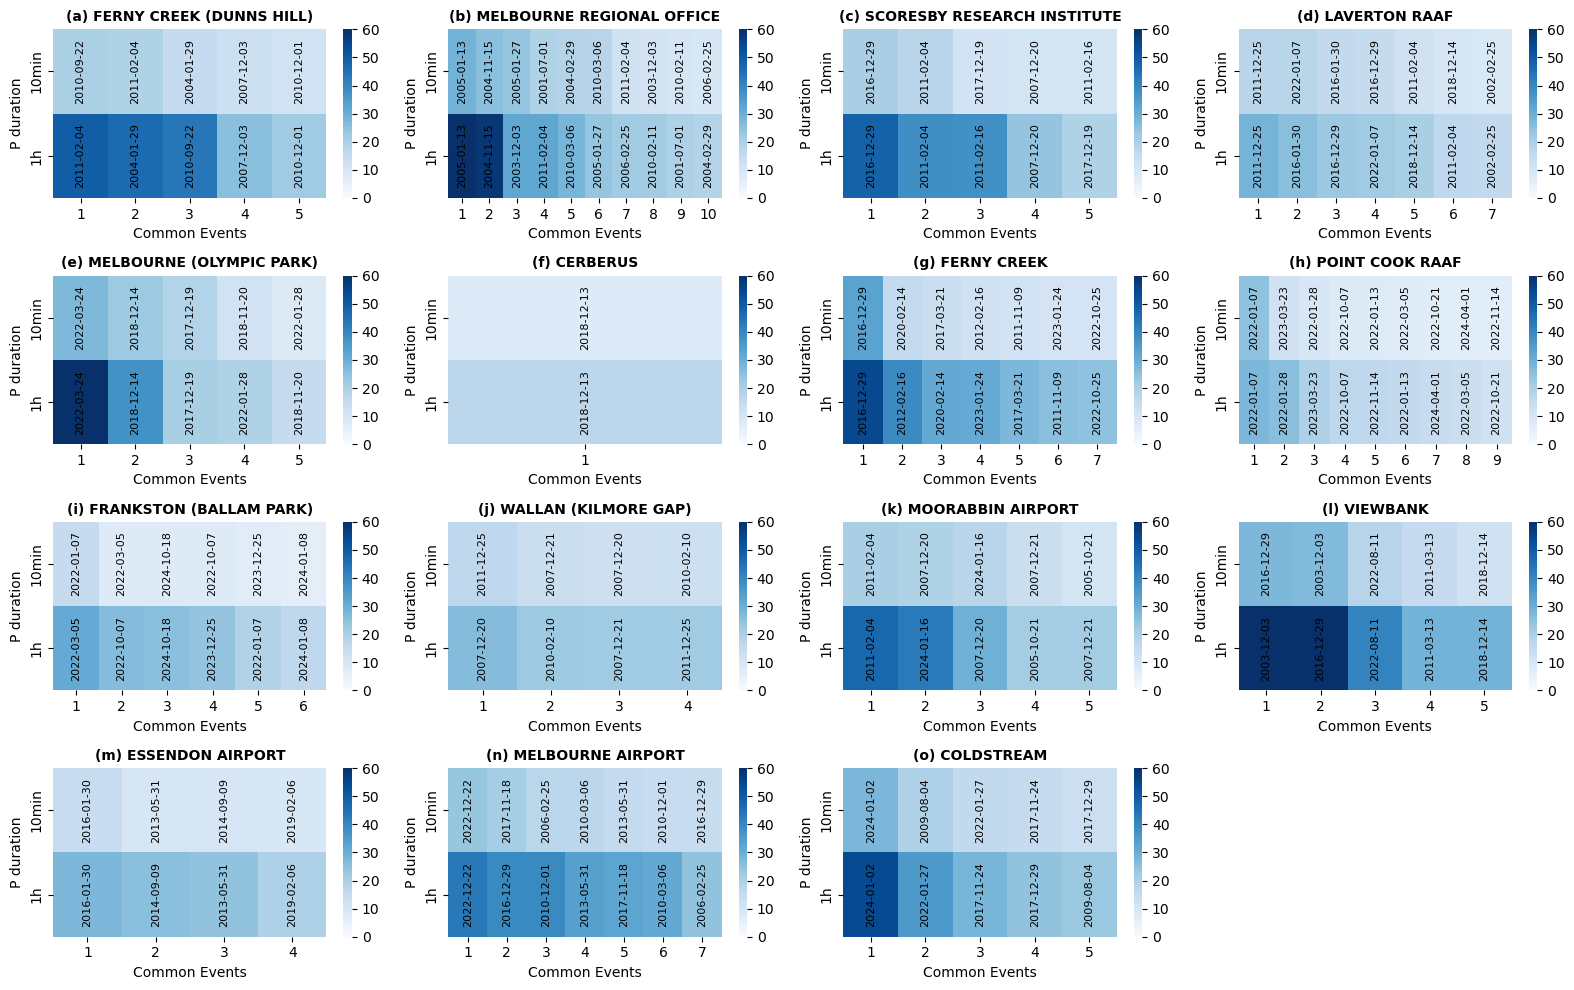

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Define the interval order (if not defined already)
interval_order = ['10min', '1h']

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")

def plot_filtered_heatmap_per_station():
    num_stations = len(filtered_top_10_events_all_stations)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10))
    axes = axes.flatten()

    for idx, (station, events) in enumerate(filtered_top_10_events_all_stations.items()):
        if idx >= 16:  # Limit to 16 subplots
            break
        ax = axes[idx]

        # Build event data for the heatmap, now including event date
        event_data = []
        for interval in interval_order:
            if interval in events:
                df = events[interval][['Date', 'Precipitation']].copy()
                # Ensure the Date is a string
                df['Date'] = df['Date'].astype(str)
                # Record each event with its rank, precipitation, and date
                for rank, (date, value) in enumerate(zip(df['Date'], df['Precipitation']), 1):
                    event_data.append([interval, rank, value, date])
                    
        if event_data:
            # Create DataFrame from event data; columns: Interval, Rank, Precipitation, Date
            event_df = pd.DataFrame(event_data, columns=['Interval', 'Rank', 'Precipitation', 'Date'])
            # Make sure the 'Interval' column is categorical with our defined order
            event_df['Interval'] = pd.Categorical(event_df['Interval'], categories=interval_order, ordered=True)
            
            # Pivot the DataFrame to get a matrix of Precipitation values (for the heatmap)
            event_df_pivot = event_df.pivot(index='Interval', columns='Rank', values='Precipitation')
            
            # Plot heatmap of precipitation values
            sns.heatmap(event_df_pivot, cmap='Blues', annot=False, fmt='.1f', ax=ax, vmin=0, vmax=60)
            
            # Now annotate each cell with the event date.
            # We loop over the pivoted table using the original event_df.
            # Since the heatmap's cells are centered at (col_index + 0.5, row_index + 0.5),
            # we find the positions via the pivot table index/columns.
            for (interval, rank), date in event_df.set_index(['Interval', 'Rank'])['Date'].items():
                # Get the row and column indices from the pivot table
                if interval in event_df_pivot.index and rank in event_df_pivot.columns:
                    row_idx = event_df_pivot.index.get_loc(interval)
                    col_idx = event_df_pivot.columns.get_loc(rank)
                    # Here, we decide on a rotation: if the date string is long, we rotate it.
                    rotation_angle = 90
                    ax.text(col_idx + 0.5, row_idx + 0.5, date,
                            ha='center', va='center', fontsize=8,
                            rotation=rotation_angle, color='black',
                            bbox=dict(facecolor='None', alpha=0.7, edgecolor='none'))
            
            subplot_label = string.ascii_lowercase[idx]  # Labels: a, b, c, etc.
            ax.set_title(f"({subplot_label}) {station}", fontsize=10, fontweight="bold")
            ax.set_xlabel('Common Events')
            ax.set_ylabel('P duration')
        else:
            ax.text(0.5, 0.5, "No events", ha='center', va='center', transform=ax.transAxes)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'{shape_path}/figure/top_10_heatmap_{target_region}_all_stations_common_with_dates.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function
plot_filtered_heatmap_per_station()


Filtering complete. 15 stations have common events.


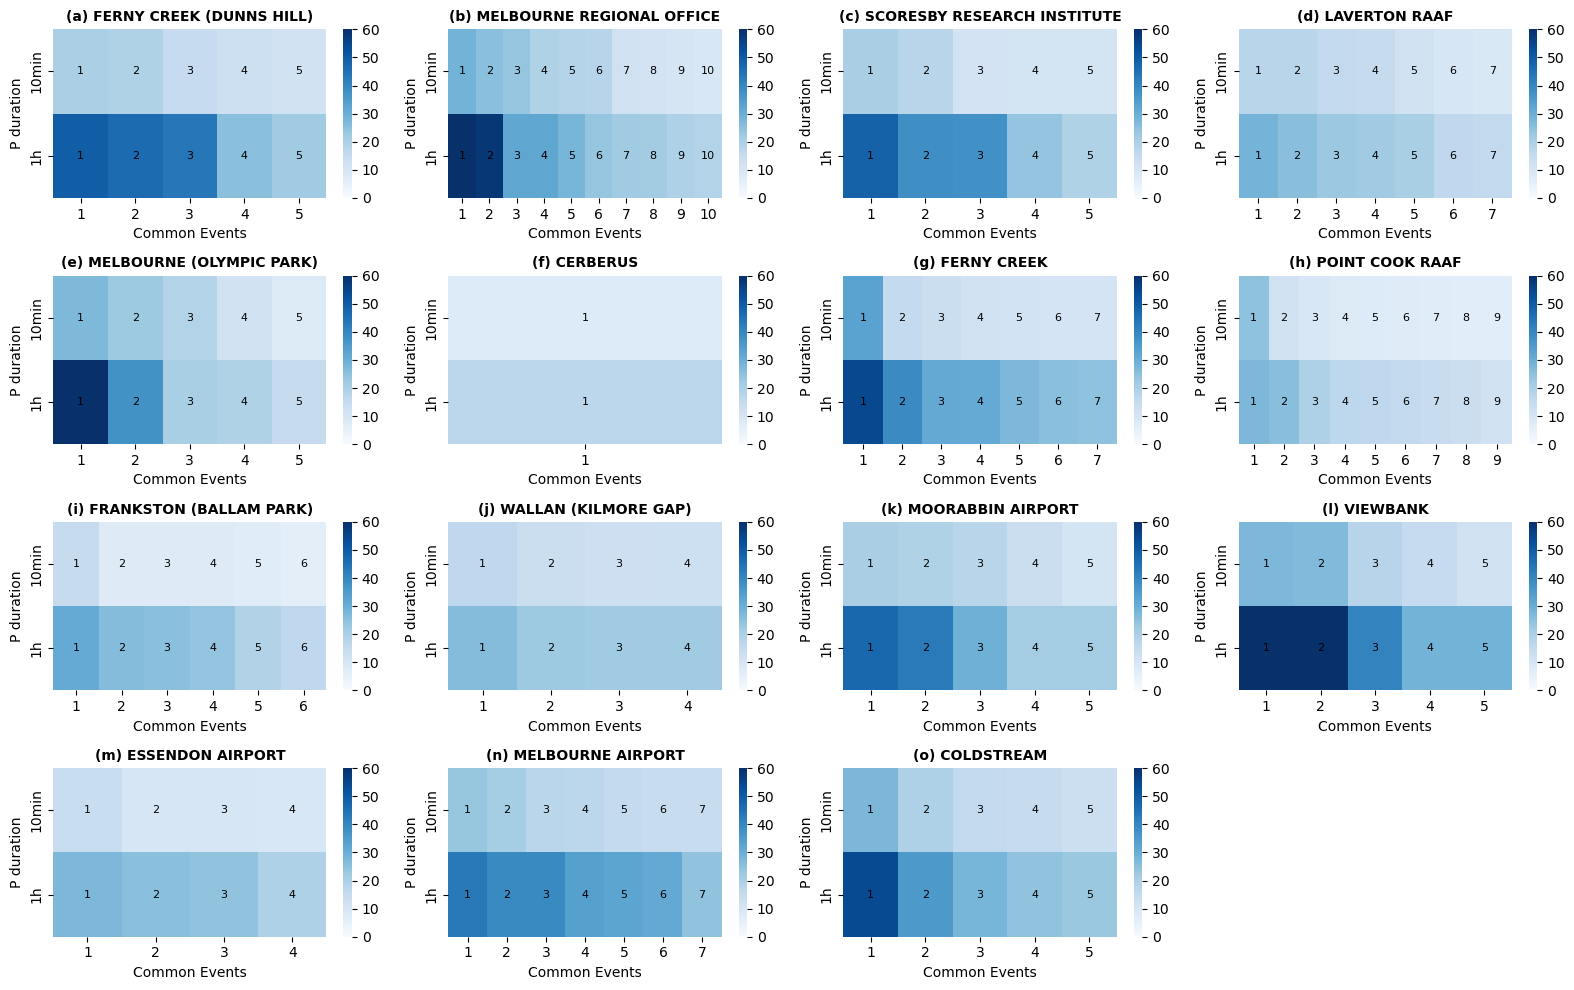

In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Define the interval order (if not defined already)
interval_order = ['10min', '1h']

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")

def plot_filtered_heatmap_per_station():
    num_stations = len(filtered_top_10_events_all_stations)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10))
    axes = axes.flatten()

    for idx, (station, events) in enumerate(filtered_top_10_events_all_stations.items()):
        if idx >= 16:  # Limit to 16 subplots
            break
        ax = axes[idx]

        # Build event data for the heatmap (using each interval's extreme precipitation values)
        # This time, we include the event rank
        event_data = []
        for interval in interval_order:
            if interval in events:
                df = events[interval][['Date', 'Precipitation']].copy()
                # Record each event with its rank (order in DataFrame)
                for rank, value in enumerate(df['Precipitation'].values, 1):
                    # We store the rank as string to annotate later
                    event_data.append([interval, rank, value])
        if event_data:
            # Create DataFrame from the event data
            event_df = pd.DataFrame(event_data, columns=['Interval', 'Rank', 'Precipitation'])
            event_df['Interval'] = pd.Categorical(event_df['Interval'], categories=interval_order, ordered=True)
            event_df_pivot = event_df.pivot(index='Interval', columns='Rank', values='Precipitation')
            
            # Plot heatmap
            sns.heatmap(event_df_pivot, cmap='Blues', annot=False, fmt='.1f', ax=ax, vmin=0, vmax=60)
            
            # Annotate the heatmap with the event rank (instead of date)
            # We use the pivot table index and columns to determine the cell locations.
            for (interval, rank), value in event_df.set_index(['Interval', 'Rank'])['Precipitation'].items():
                # Get row and column indices in the pivot table
                if interval in event_df_pivot.index and rank in event_df_pivot.columns:
                    row_idx = event_df_pivot.index.get_loc(interval)
                    col_idx = event_df_pivot.columns.get_loc(rank)
                    # Annotate with the rank (as a string)
                    ax.text(col_idx + 0.5, row_idx + 0.5, str(rank),
                            ha='center', va='center', fontsize=8,
                            color='black', bbox=dict(facecolor='None', alpha=0.7, edgecolor='none'))
            
            subplot_label = string.ascii_lowercase[idx]  # Labels: a, b, c, etc.
            ax.set_title(f"({subplot_label}) {station}", fontsize=10, fontweight="bold")
            ax.set_xlabel('Common Events')
            ax.set_ylabel('P duration')
        else:
            ax.text(0.5, 0.5, "No events", ha='center', va='center', transform=ax.transAxes)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{shape_path}/figure/top_10_heatmap_{target_region}_all_stations_common_with_rank.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function
plot_filtered_heatmap_per_station()

Filtering complete. 15 stations have common events.


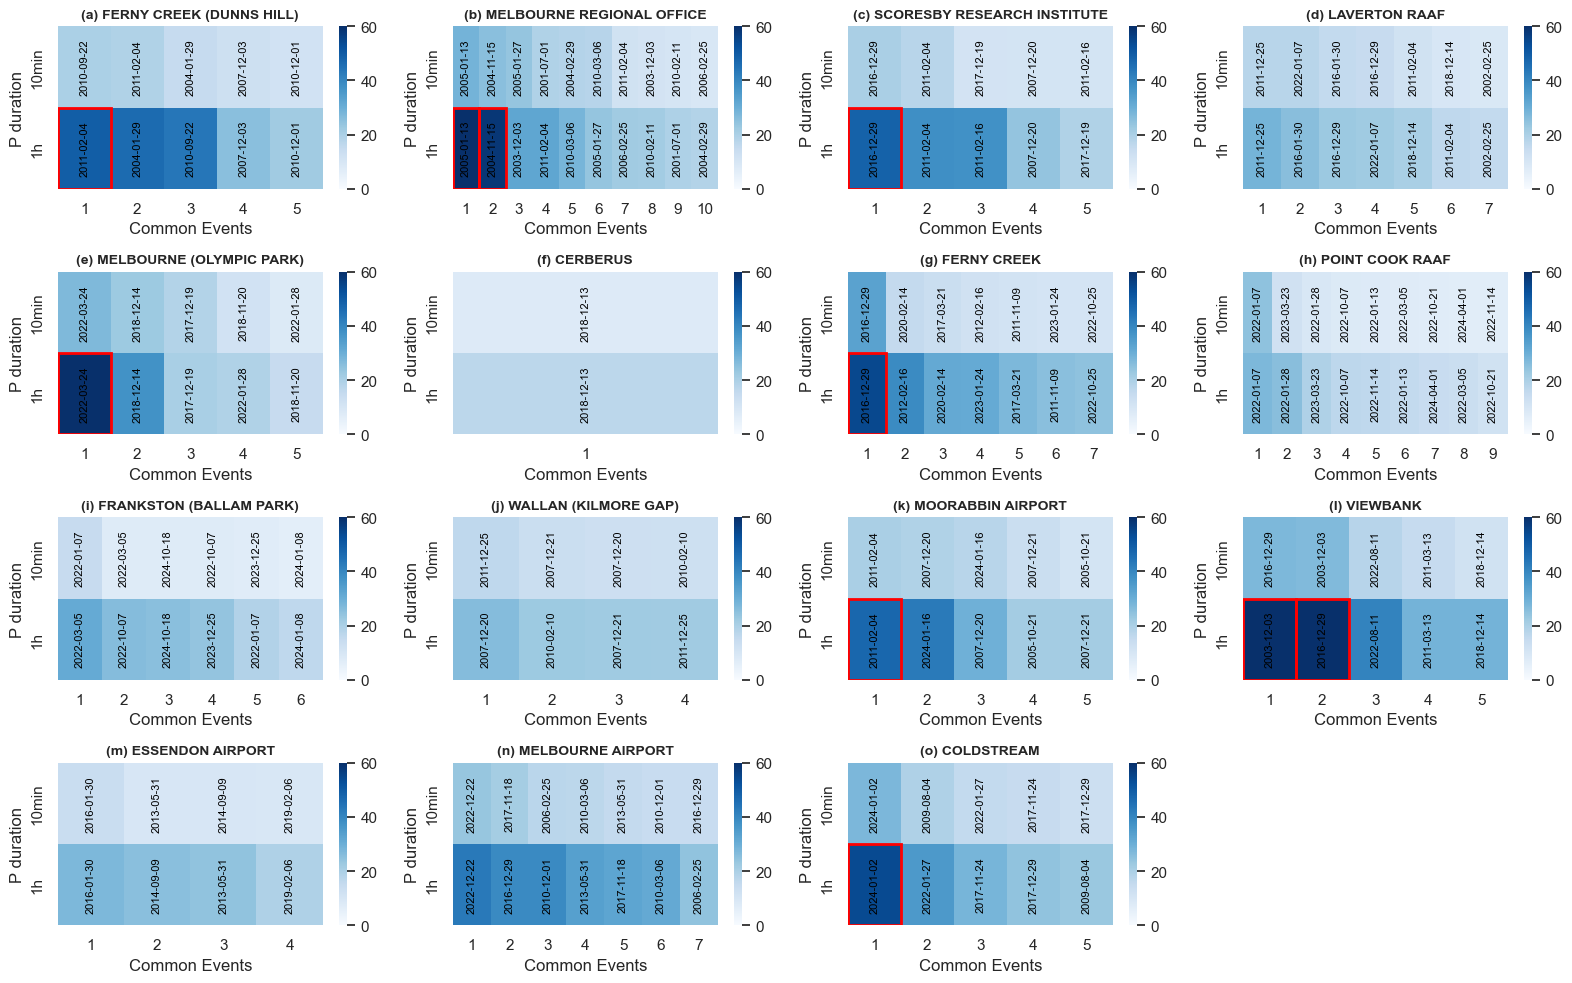

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from matplotlib.patches import Rectangle

shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'
# Define the interval order (if not defined already)
interval_order = ['10min', '1h']

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")

# ----------------------------------------------------------
# Compute global top 10 1h events across all stations
# ----------------------------------------------------------
global_1h_events = []
for station, events in filtered_top_10_events_all_stations.items():
    if '1h' in events:
        df = events['1h'][['Date', 'Precipitation']].copy()
        # Ensure the Date is a string
        df['Date'] = df['Date'].astype(str)
        # Enumerate events in the order they appear (assumed to be pre-filtered top events)
        for rank, row in enumerate(df.itertuples(index=False), start=1):
            global_1h_events.append({
                'station': station,
                'rank': rank,
                'date': row.Date,
                'precipitation': row.Precipitation
            })

# Sort the events by precipitation in descending order and select the top 10
global_top10 = sorted(global_1h_events, key=lambda x: x['precipitation'], reverse=True)[:10]
# Create a set of (station, rank) keys for quick lookup when plotting
global_top10_keys = {(event['station'], event['rank']) for event in global_top10}

# ----------------------------------------------------------
# Plotting function
# ----------------------------------------------------------
def plot_filtered_heatmap_per_station():
    num_stations = len(filtered_top_10_events_all_stations)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10))
    axes = axes.flatten()

    for idx, (station, events) in enumerate(filtered_top_10_events_all_stations.items()):
        if idx >= 16:  # Limit to 16 subplots
            break
        ax = axes[idx]

        # Build event data for the heatmap, including event date
        event_data = []
        for interval in interval_order:
            if interval in events:
                df = events[interval][['Date', 'Precipitation']].copy()
                # Ensure the Date is a string
                df['Date'] = df['Date'].astype(str)
                # Record each event with its rank, precipitation, and date
                for rank, (date, value) in enumerate(zip(df['Date'], df['Precipitation']), start=1):
                    event_data.append([interval, rank, value, date])
                    
        if event_data:
            # Create DataFrame from event data; columns: Interval, Rank, Precipitation, Date
            event_df = pd.DataFrame(event_data, columns=['Interval', 'Rank', 'Precipitation', 'Date'])
            # Make sure the 'Interval' column is categorical with our defined order
            event_df['Interval'] = pd.Categorical(event_df['Interval'], categories=interval_order, ordered=True)
            
            # Pivot the DataFrame to get a matrix of Precipitation values (for the heatmap)
            event_df_pivot = event_df.pivot(index='Interval', columns='Rank', values='Precipitation')
            
            # Plot heatmap of precipitation values
            sns.heatmap(event_df_pivot, cmap='Blues', annot=False, fmt='.1f', ax=ax, vmin=0, vmax=60)
            
            # Annotate each cell with the event date.
            for (interval, rank), date in event_df.set_index(['Interval', 'Rank'])['Date'].items():
                if interval in event_df_pivot.index and rank in event_df_pivot.columns:
                    row_idx = event_df_pivot.index.get_loc(interval)
                    col_idx = event_df_pivot.columns.get_loc(rank)
                    rotation_angle = 90  # Rotate the date text for clarity
                    ax.text(col_idx + 0.5, row_idx + 0.5, date,
                            ha='center', va='center', fontsize=8,
                            rotation=rotation_angle, color='black',
                            bbox=dict(facecolor='None', alpha=0.7, edgecolor='none'))
            
            # Highlight global top 10 events for the '1h' interval with a red rectangle
            if '1h' in events:
                df_1h = events['1h'][['Date', 'Precipitation']].copy()
                df_1h['Date'] = df_1h['Date'].astype(str)
                for rank, (date, value) in enumerate(zip(df_1h['Date'], df_1h['Precipitation']), start=1):
                    # Only draw a red rectangle if this event is in the global top 10 list
                    if (station, rank) in global_top10_keys:
                        if rank in event_df_pivot.columns:
                            row_idx = event_df_pivot.index.get_loc('1h')
                            col_idx = event_df_pivot.columns.get_loc(rank)
                            rect = Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='red', lw=2, zorder=3)
                            ax.add_patch(rect)
            
            subplot_label = string.ascii_lowercase[idx]  # Labels: a, b, c, etc.
            ax.set_title(f"({subplot_label}) {station}", fontsize=10, fontweight="bold")
            ax.set_xlabel('Common Events')
            ax.set_ylabel('P duration')
        else:
            ax.text(0.5, 0.5, "No events", ha='center', va='center', transform=ax.transAxes)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'{shape_path}/figure/top_10_heatmap_{target_region}_all_stations_common_with_dates_with_top_of_top10.jpg',
                format='jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function
plot_filtered_heatmap_per_station()


Filtering complete. 15 stations have common events.


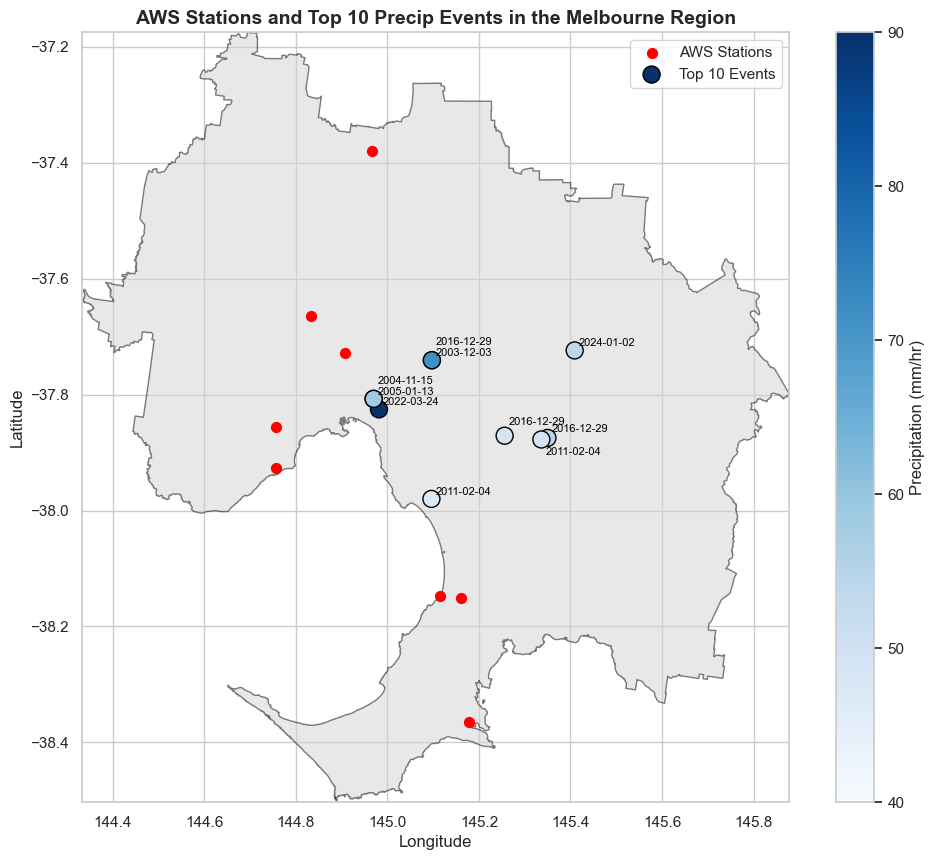

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN

# --- Assumptions ---
# global_top10 is a list of dictionaries with keys: station, rank, date, precipitation.
# stations is your DataFrame with station metadata.
# melbourne_shp is your target region (shapefile for Melbourne) and stations_in_melbourne are AWS stations within that region.
shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'
# Define the interval order (if not defined already)
interval_order = ['10min', '1h']

print(f"Filtering complete. {len(filtered_top_10_events_all_stations)} stations have common events.")

# ----------------------------------------------------------
# Compute global top 10 1h events across all stations
# ----------------------------------------------------------
global_1h_events = []
for station, events in filtered_top_10_events_all_stations.items():
    if '1h' in events:
        df = events['1h'][['Date', 'Precipitation']].copy()
        # Ensure the Date is a string
        df['Date'] = df['Date'].astype(str)
        # Enumerate events in the order they appear (assumed to be pre-filtered top events)
        for rank, row in enumerate(df.itertuples(index=False), start=1):
            global_1h_events.append({
                'station': station,
                'rank': rank,
                'date': row.Date,
                'precipitation': row.Precipitation
            })

# Sort the events by precipitation in descending order and select the top 10
global_top10 = sorted(global_1h_events, key=lambda x: x['precipitation'], reverse=True)[:10]
# Create a set of (station, rank) keys for quick lookup when plotting
global_top10_keys = {(event['station'], event['rank']) for event in global_top10}

# --- Prepare Global Top 10 Data ---
# Convert the global_top10 list into a DataFrame
global_top10_df = pd.DataFrame(global_top10)

# Convert the 'date' column to datetime and create a 'Time' column (if not already datetime)
global_top10_df['Time'] = pd.to_datetime(global_top10_df['date'])

# Merge with station metadata; note: using 'Station_name' from stations for matching
# global_top10_df = global_top10_df.merge(
#     stations[['station', 'Longitude', 'Latitude']],
#     left_on='station', right_on='station',
#     how='left'
# )

global_top10_df = global_top10_df.merge(
    stations[['Station_name', 'Longitude', 'Latitude']],
    left_on='station', right_on='Station_name', how='left'
)

# Convert to a GeoDataFrame for mapping
global_top10_gdf = gpd.GeoDataFrame(
    global_top10_df,
    geometry=gpd.points_from_xy(global_top10_df['Longitude'], global_top10_df['Latitude']),
    crs="EPSG:4326"
)

# --- Plotting ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))
shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'

# Plot the target region (e.g. Melbourne) as background
target_region_shp.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Plot AWS stations within Melbourne (optional)
stations_in_region.plot(ax=ax, color='red', markersize=50, label='AWS Stations')

# Plot the global top 10 events as scatter points, colored by precipitation intensity
sc = ax.scatter(
    global_top10_gdf.geometry.x,
    global_top10_gdf.geometry.y,
    c=global_top10_gdf['precipitation'],
    cmap='Blues',
    s=150,
    edgecolor='black',
    label='Top 10 Events',
    vmin=40,
vmax=90,
)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label("Precipitation (mm/hr)", fontsize=12)

# --- Annotation Offsetting Using DBSCAN Clustering ---
# Extract coordinates for clustering
coords = np.array([[geom.x, geom.y] for geom in global_top10_gdf.geometry])
# Cluster nearby points (adjust eps as needed)
db = DBSCAN(eps=0.005, min_samples=1).fit(coords)
global_top10_gdf = global_top10_gdf.copy()
global_top10_gdf['cluster'] = db.labels_

# For each cluster, compute an offset for annotations so they don't overlap
offsets = {}  # dictionary: index -> offset
for cluster in global_top10_gdf['cluster'].unique():
    cluster_points = global_top10_gdf[global_top10_gdf['cluster'] == cluster]
    # Sort points by their y-coordinate to stagger labels vertically
    cluster_points = cluster_points.assign(y_coord=cluster_points.geometry.apply(lambda geom: geom.y))
    sorted_indices = cluster_points.sort_values('y_coord').index
    # Assign an incremental offset for each point in the same cluster
    for j, idx in enumerate(sorted_indices):
        offsets[idx] = 3 + j * 8  # starting at 3, then increasing by 8 for each subsequent point

# Annotate each top 10 event with its date (formatted as YYYY-MM-DD)
for idx, row in global_top10_gdf.iterrows():
    event_date = row["Time"].strftime("%Y-%m-%d") if pd.notnull(row["Time"]) else ""
    offset_y = offsets.get(idx, 3)
    # Apply manual adjustments for specific stations
    station_name = row["station"]
    if station_name == "FERNY CREEK":
        offset_y = offsets.get(idx, 3) + 1.5
    elif station_name == "FERNY CREEK (DUNNS HILL)":
        offset_y = offsets.get(idx, 3) - 14
    elif station_name == "SCORESBY RESEARCH INSTITUTE":
        offset_y = offsets.get(idx, 3) + 5
        
    ax.annotate(
        event_date,
        xy=(row.geometry.x, row.geometry.y),
        xytext=(3, offset_y),
        textcoords="offset points",
        fontsize=8,
        color="black"
    )

# Set plot extent based on the region's bounds
minx, miny, maxx, maxy = target_region_shp.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title(f"AWS Stations and Top 10 Precip Events in the {region_name} Region", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend()

plt.savefig(f'{shape_path}/figure/topoftop_10_map_melbourne.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()
